In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm
from sklearn.linear_model import Lasso
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sys
import os
import pickle
from time import time

cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "Bolasso":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)

from numba import jit

In [2]:
# import the right librairies
from utils.synthetic_data import generate_synthetic_data, load_data
from utils.bolasso_algorithm import bolasso

## Criterion (2) False

In [3]:
# load the data
data = load_data(p = 16, r = 8, n = 1000, rep=256, cache_path = os.path.join(os.getcwd(), "data"), criterion_2 = False)

>> data loaded at : 
 >> C:\Users\baptc\Documents\GM\INSA\3A\S9\Parcimonie\articles\Bolasso\data\criterion_2_non_ok.pkl


In [4]:
data["crit_2"]

1.9519418940278

### The simple Lasso - regression

In [5]:
%%capture
# do the multiple lasso regressions
mu_range = np.exp(- np.linspace(0, 15, 50))
final_grid = np.zeros((16, 50))
for i in tqdm(range(100)):
    X, y = data["X"][i], data["Y"][i]
    for k in range(50):
        mu = mu_range[k]
        lasso_reg = Lasso(alpha=mu, max_iter=10000)
        lasso_reg.fit(X, y)
        coef = lasso_reg.coef_ 
        final_grid[:,k] += (coef != 0)*1
;

C:\Users\baptc\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


''

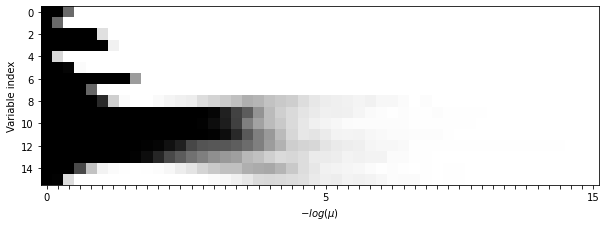

In [6]:
figure = plt.figure(figsize=(10,10))
plt.imshow(1 - final_grid / 100, cmap="Greys", vmin=0, vmax=1)
ax = plt.gca()

# the x-axis
ax.set_xticks(range(50))
ax.set_xlabel(np.linspace(0, 15, 50))
ax.set_xlabel("$-log(\mu)$")
d = dict(zip([0, 25, 49], [0, 5, 15]))
x_label_list = [str(d[i]) if i in [0, 25, 49] else str("") for i in range(50)]
ax.set_xticklabels(x_label_list)
ax.set_ylabel("Variable index")
;

# Bolasso

In [7]:
%%capture

nb_rep = 100
nb_mu = 50 # nu
m = 128

mu_range = np.exp(- np.linspace(0, 15, nb_mu))
final_grid = np.zeros((16, nb_mu))
for i in tqdm(range(nb_rep)):
    X, y = data["X"][i], data["Y"][i]
    for k in range(nb_mu):
        mu = mu_range[k]
        res = bolasso(X, y, m=m, mu=mu)
        J = res["J"] 
        final_grid[:,k] += (J != 0)*1


C:\Users\baptc\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


''

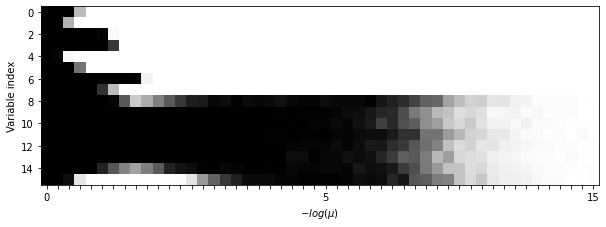

In [8]:
figure = plt.figure(figsize=(10,10))
plt.imshow(1 - final_grid / 100, cmap="Greys", vmin=0, vmax=1)
ax = plt.gca()

# the x-axis
ax.set_xticks(range(50))
ax.set_xlabel(np.linspace(0, 15, 50))
ax.set_xlabel("$-log(\mu)$")
d = dict(zip([0, 25, 49], [0, 5, 15]))
x_label_list = [str(d[i]) if i in [0, 25, 49] else str("") for i in range(50)]
ax.set_xticklabels(x_label_list)
ax.set_ylabel("Variable index")
;

## Criterion (2) : True

In [9]:
# load the data
data = load_data(p = 16, r = 8, n = 1000, rep=256, cache_path = os.path.join(os.getcwd(), "data"), criterion_2 = True)
data["crit_2"]

>> data loaded at : 
 >> C:\Users\baptc\Documents\GM\INSA\3A\S9\Parcimonie\articles\Bolasso\data\criterion_2_ok.pkl


0.9151764636195251

### The simple Lasso - regression

In [10]:
%%capture
# do the multiple lasso regressions
mu_range = np.exp(- np.linspace(0, 15, 50))
final_grid = np.zeros((16, 50))
for i in tqdm(range(100)):
    X, y = data["X"][i], data["Y"][i]
    for k in range(50):
        mu = mu_range[k]
        lasso_reg = Lasso(alpha=mu, max_iter=10000)
        lasso_reg.fit(X, y)
        coef = lasso_reg.coef_ 
        final_grid[:,k] += (coef != 0)*1
;

C:\Users\baptc\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


''

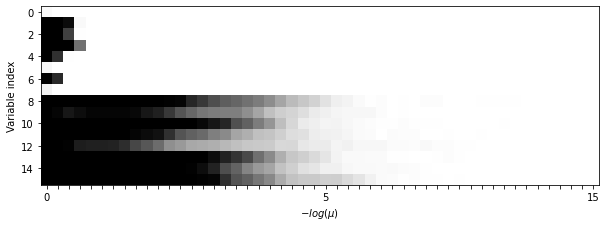

In [11]:
figure = plt.figure(figsize=(10,10))
plt.imshow(1 - final_grid / 100, cmap="Greys", vmin=0, vmax=1)
ax = plt.gca()

# the x-axis
ax.set_xticks(range(50))
ax.set_xlabel(np.linspace(0, 15, 50))
ax.set_xlabel("$-log(\mu)$")
d = dict(zip([0, 25, 49], [0, 5, 15]))
x_label_list = [str(d[i]) if i in [0, 25, 49] else str("") for i in range(50)]
ax.set_xticklabels(x_label_list)
ax.set_ylabel("Variable index")
;

# Bolasso

In [12]:
%%capture

nb_rep = 100
nb_mu = 50 # nu
m = 128

mu_range = np.exp(- np.linspace(0, 15, nb_mu))
final_grid = np.zeros((16, nb_mu))
for i in tqdm(range(nb_rep)):
    X, y = data["X"][i], data["Y"][i]
    for k in range(nb_mu):
        mu = mu_range[k]
        res = bolasso(X, y, m=m, mu=mu)
        J = res["J"] 
        final_grid[:,k] += (J != 0)*1


C:\Users\baptc\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


''

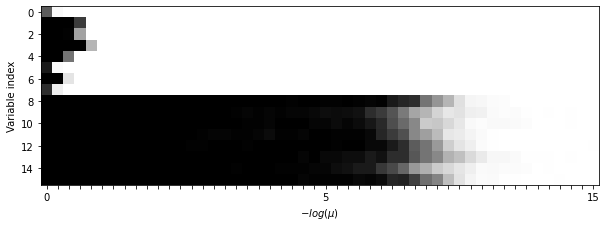

In [13]:
figure = plt.figure(figsize=(10,10))
plt.imshow(1 - final_grid / 100, cmap="Greys", vmin=0, vmax=1)
ax = plt.gca()

# the x-axis
ax.set_xticks(range(50))
ax.set_xlabel(np.linspace(0, 15, 50))
ax.set_xlabel("$-log(\mu)$")
d = dict(zip([0, 25, 49], [0, 5, 15]))
x_label_list = [str(d[i]) if i in [0, 25, 49] else str("") for i in range(50)]
ax.set_xticklabels(x_label_list)
ax.set_ylabel("Variable index")
;

# Speed up Bolasso with numba (code optimizer / parallel computing)

In [ ]:
%%capture

data_non_ok = data.copy() 

start = time()
nb_rep = 100
nb_mu = 50 # nu
m = 128

mu_range = np.exp(- np.linspace(0, 15, nb_mu))
final_grid_non_ok = np.zeros((16, nb_mu))

@jit(parallel=True)
def bolasso_it(X, y):   
    intermediate_grid = np.zeros((16, nb_mu))
    for k in range(nb_mu):
        mu = mu_range[k]
        res = bolasso(X, y, m=m, mu=mu)
        J = res["J"] 
        intermediate_grid[:,k] = (J != 0)*1
    return intermediate_grid

list_grid_non_ok = []
list_X_non_ok = data_non_ok['X']
list_Y_non_ok = data_non_ok['Y']

for X, y in tqdm(zip(list_X_non_ok, list_Y_non_ok)):
    list_grid_non_ok.append(bolasso_it(X, y))
        
list_grid_non_ok = np.array(list_grid_non_ok)
final_grid_non_ok = np.sum(list_grid_non_ok, axis = 0)
end = time()